In [1]:
import pyspark
from random import random
from operator import add
 
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("ChinaAnalysis").master("spark://172.22.0.2:7077").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/07 23:44:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.format("csv").option("header", "true").option("inferschema","true").load("data/owid-energy-data.csv.gz")


In [7]:
df_ch = df.select('year','population','electricity_demand').where(("country == 'China' AND electricity_demand IS NOT NULL"))
df_ch.show()

+----+----------+------------------+
|year|population|electricity_demand|
+----+----------+------------------+
|2000|1264099072|           1346.85|
|2001|1272739584|           1472.19|
|2002|1280926080|           1645.61|
|2003|1288873344|           1903.22|
|2004|1296816768|           2197.23|
|2005|1304887552|           2494.08|
|2006|1313086592|           2858.84|
|2007|1321513216|           3271.23|
|2008|1330167168|           3482.96|
|2009|1339125632|           3703.26|
|2010|1348191360|           4193.65|
|2011|1357095424|           4700.28|
|2012|1366560768|           4976.76|
|2013|1376100352|            5420.4|
|2014|1385189632|           5783.04|
|2015|1393715456|           5802.14|
|2016|1401889664|           6120.44|
|2017|1410275968|           6591.39|
|2018|1417069440|           7150.92|
|2019|1421864064|           7486.63|
+----+----------+------------------+
only showing top 20 rows



In [11]:
import matplotlib.pyplot as plt
df_pl = df_pl.orderBy('year')
y = df_pl.select('year').rdd.flatMap(lambda x: x).collect()
pop = df_pl.select('population').rdd.flatMap(lambda x: x).collect()
dem = df_pl.select('electricity_demand').rdd.flatMap(lambda x: x).collect()

In [12]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
 
va=VectorAssembler().setInputCols(["year"]).setOutputCol("features")
df_chf = va.transform(df_ch)
df_chf.show(5)
 
lr = LinearRegression()\
  .setMaxIter(10)\
  .setRegParam(3.0)\
  .setElasticNetParam(0.5)\
  .setFeaturesCol("features")\
  .setLabelCol("electricity_demand")
model = lr.fit(df_chf)

+----+----------+------------------+--------+
|year|population|electricity_demand|features|
+----+----------+------------------+--------+
|2000|1264099072|           1346.85|[2000.0]|
|2001|1272739584|           1472.19|[2001.0]|
|2002|1280926080|           1645.61|[2002.0]|
|2003|1288873344|           1903.22|[2003.0]|
|2004|1296816768|           2197.23|[2004.0]|
+----+----------+------------------+--------+
only showing top 5 rows



In [13]:
print(f'RMSE: {model.summary.rootMeanSquaredError}')
print(f'r2: {model.summary.r2}')
print(f'iterations: {model.summary.totalIterations}')
print(f'demand = {model.coefficients}*year {"+" if model.intercept > 0 else ""} {model.intercept}')

RMSE: 197.62738324653978
r2: 0.9926039840377885
iterations: 3
demand = [344.7007425311926]*year  -688510.1175780544


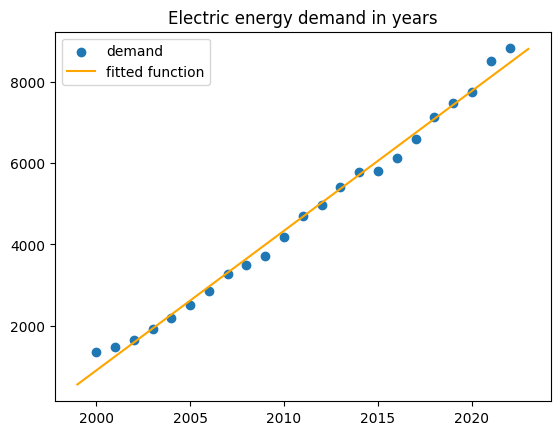

In [14]:
import numpy as np
# from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.ml.linalg import Vectors
 
xmin = np.min(y)
xmax = np.max(y)
xx = np.linspace(xmin-1,xmax+1,100)
 
yy = [model.predict(Vectors.dense([x])) for x in xx]
 
plt.scatter(y,dem,label='demand')
plt.plot(xx,yy,label='fitted function',c='orange')
plt.legend()
plt.title('Electric energy demand in years')
plt.show()

In [ ]:
spark.stop()